<a href="https://colab.research.google.com/github/TaraRasti/Deep-Learning/blob/main/ECG/ECG_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]


-N : Non-ecotic beats (normal beat)
-S : Supraventricular ectopic beats
-V : Ventricular ectopic beats
-F : Fusion Beats
-Q : Unknown Beats

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
import os
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LayerNormalization
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [3]:

for dirname, _, filenames in os.walk('/content/drive/MyDrive/archive-2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/archive-2/mitbih_test.csv
/content/drive/MyDrive/archive-2/mitbih_train.csv
/content/drive/MyDrive/archive-2/ptbdb_abnormal.csv
/content/drive/MyDrive/archive-2/ptbdb_normal.csv


In [4]:
train_df=pd.read_csv('/content/drive/MyDrive/archive-2/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/archive-2/mitbih_test.csv',header=None)

**Balance of dataset**

In [5]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)



0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


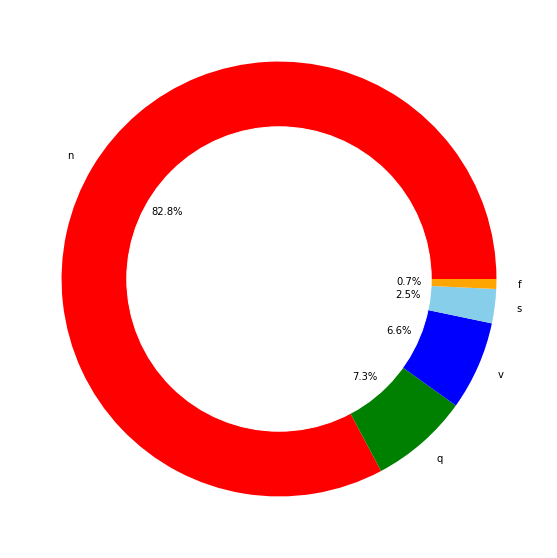

In [6]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [7]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [8]:
equilibre=train_df[187].value_counts()
print(equilibre)


4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


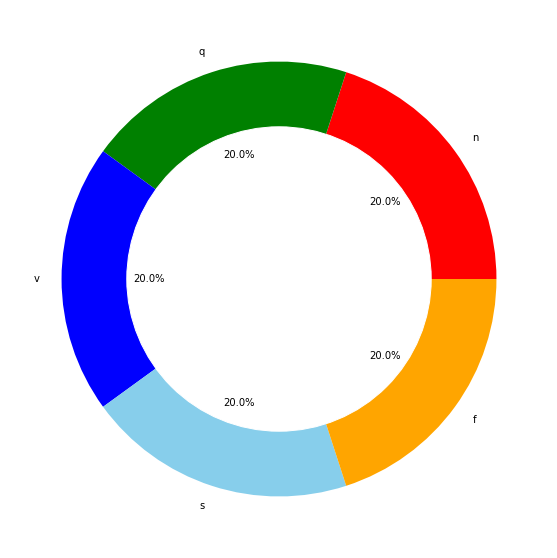

In [9]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

**Classes**

In [10]:
c = train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

I take one sample per class and I store it in a dataframe in order to have an example. 

In [11]:
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
1747,1.000000,0.951128,0.558271,0.394737,0.390977,0.343985,0.298872,0.250000,0.203008,0.156015,0.131579,0.110902,0.107143,0.095865,0.092105,0.088346,0.092105,0.080827,0.078947,0.069549,0.067669,0.056391,0.054511,0.046992,0.035714,0.031955,0.015038,0.007519,0.009398,0.000000,0.011278,0.020677,0.048872,0.063910,0.084586,0.116541,0.140977,0.154135,0.167293,0.157895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73618,1.000000,0.672289,0.000000,0.004819,0.154217,0.168675,0.146988,0.115663,0.098795,0.091566,0.103614,0.101205,0.110843,0.098795,0.122892,0.103614,0.127711,0.137349,0.151807,0.156627,0.180723,0.185542,0.195181,0.216867,0.228916,0.221687,0.243373,0.238554,0.236145,0.207229,0.195181,0.161446,0.142169,0.110843,0.115663,0.101205,0.103614,0.098795,0.101205,0.096386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
75651,0.011811,0.000000,0.035433,0.108924,0.202100,0.262467,0.342520,0.422572,0.460630,0.557743,0.682415,0.695538,0.669291,0.671916,0.685039,0.695538,0.699475,0.708661,0.719160,0.729659,0.740157,0.749344,0.763780,0.778215,0.786089,0.800525,0.812336,0.814961,0.807087,0.793963,0.782152,0.755906,0.725722,0.702100,0.675853,0.657480,0.628609,0.610236,0.599738,0.590551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80566,1.000000,0.790323,0.361290,0.258065,0.190323,0.116129,0.090323,0.083871,0.083871,0.070968,0.067742,0.083871,0.083871,0.074194,0.064516,0.077419,0.070968,0.061290,0.070968,0.083871,0.067742,0.064516,0.048387,0.048387,0.041935,0.022581,0.009677,0.019355,0.019355,0.000000,0.003226,0.029032,0.058065,0.064516,0.074194,0.106452,0.116129,0.096774,0.100000,0.109677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
83315,1.000000,0.893617,0.641844,0.429078,0.287234,0.287234,0.287234,0.301418,0.304965,0.329787,0.304965,0.319149,0.301418,0.312057,0.312057,0.319149,0.301418,0.308511,0.297872,0.312057,0.301418,0.308511,0.297872,0.304965,0.301418,0.308511,0.301418,0.315603,0.294326,0.322695,0.315603,0.329787,0.322695,0.333333,0.333333,0.354610,0.354610,0.361702,0.368794,0.400709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


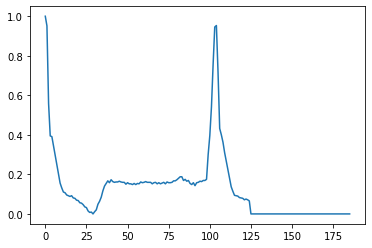

In [12]:
 plt.plot(c.iloc[0,:186])

In [13]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


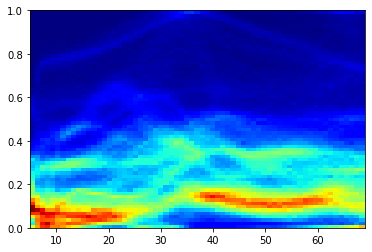

In [14]:
plot_hist(0,70,5,65)

Here is a representation for all the class. We take all the signal and map them. Like that we have an estimation what the signal can look like.

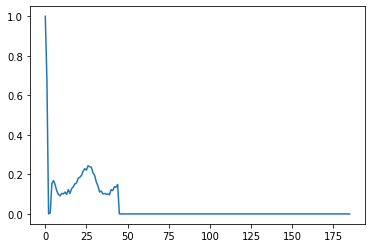

In [15]:
 plt.plot(c.iloc[1,:186])

900000
900000


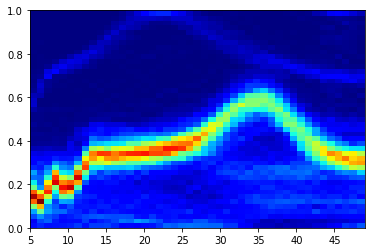

In [16]:
plot_hist(1,50,5,45)

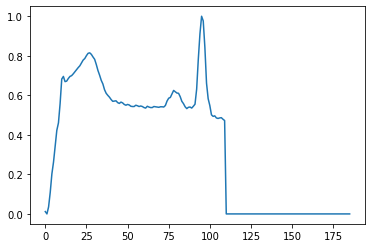

In [17]:
plt.plot(c.iloc[2,:186])

900000
900000


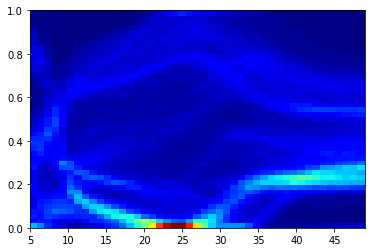

In [18]:
plot_hist(2,50,5,45)

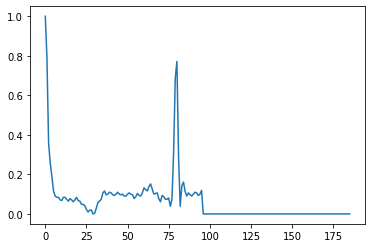

In [19]:
plt.plot(c.iloc[3,:186])

900000
900000


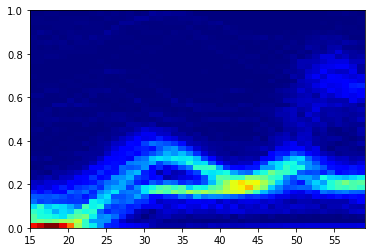

In [20]:
plot_hist(3,60,15,45)

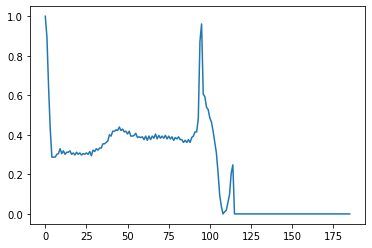

In [21]:
plt.plot(c.iloc[4,:186])

700000
700000


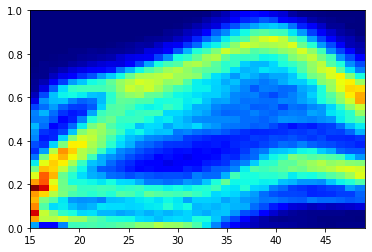

In [22]:
plot_hist(4,50,15,35)

In [23]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)


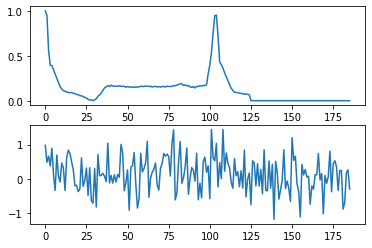

In [24]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()


In [25]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [26]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [36]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=tf.keras.layers.BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=tf.keras.layers.BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=tf.keras.layers.BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [37]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [38]:
model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/40
3125/3125 [==============================] - 105s 33ms/step - loss: 0.8970 - accuracy: 0.6562 - val_loss: 1.0877 - val_accuracy: 0.6177
Epoch 2/40
3125/3125 [==============================] - 103s 33ms/step - loss: 0.7936 - accuracy: 0.6984 - val_loss: 0.9052 - val_accuracy: 0.7076
Epoch 3/40
3125/3125 [==============================] - 101s 32ms/step - loss: 0.7604 - accuracy: 0.7109 - val_loss: 0.7557 - val_accuracy: 0.7350
Epoch 4/40
3125/3125 [==============================] - 101s 32ms/step - loss: 0.7329 - accuracy: 0.7234 - val_loss: 0.8592 - val_accuracy: 0.6884
Epoch 5/40
3125/3125 [==============================] - 100s 32ms/step - loss: 0.7072 - accuracy: 0.7325 - val_loss: 0.8415 - val_accuracy: 0.6933
Epoch 6/40
3125/3125 [==============================] - 100s 32ms/step - loss: 0.6833 - accuracy: 0.7432 - val_loss: 0.7696 - val_accuracy: 0.7323
Epoch 7/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.6572 - accuracy: 0.7522 - val_loss: 0.

Accuracy: 73.50%


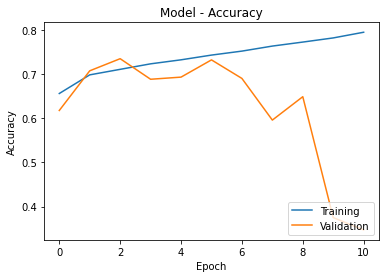

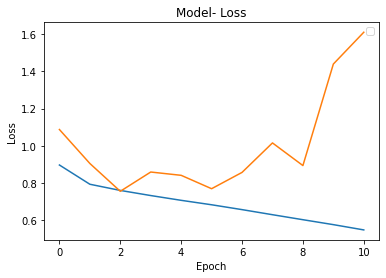

In [39]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


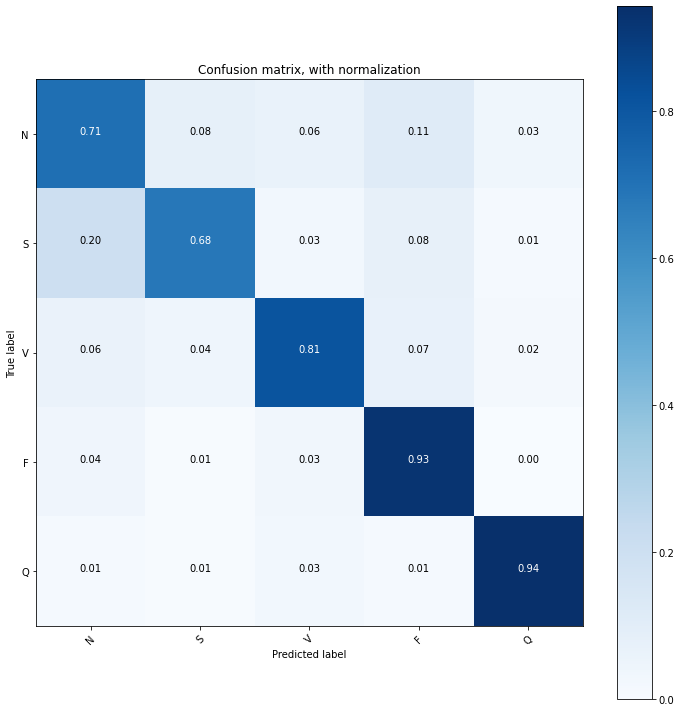

In [40]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

